# Baseball Predictions

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
cleaned = ['hsera', 'asera', 'hera', 'aera']

data_path = 'raw/train.csv'
data = pd.read_csv(data_path)

for item in cleaned:
    data.loc[data[item] > 18, item] = 18

testing_path = 'raw/data21.csv'
testing = pd.read_csv(testing_path)

testing.loc[data[item] > 18, item] = 18

data.describe()

,hrs,hra,hsera,hr,hera,ars,ara,asera,ar,aera,winner
count,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,4.640405,4.628354,4.459668,1.066056,4.301540,4.632575,4.635302,4.411378,1.064336,4.288438,0.535138
std,0.512721,0.572279,1.797360,0.380181,1.478321,0.512028,0.570607,1.703785,0.377345,1.475169,0.498826
min,3.410000,3.040000,0.000000,0.369231,0.000000,3.430000,3.040000,0.000000,0.375000,0.000000,0.000000
25%,4.300000,4.190000,3.323864,0.805195,3.440000,4.310000,4.200000,3.299255,0.803922,3.440000,0.000000
50%,4.650000,4.620000,4.224490,1.016393,4.160000,4.640000,4.640000,4.215886,1.016129,4.130000,1.000000
75%,4.980000,5.060000,5.329428,1.254237,4.910000,4.970000,5.070000,5.302115,1.254391,4.900000,1.000000
max,6.030000,6.450000,18.000000,2.527778,18.000000,6.000000,6.420000,18.000000,2.558824,18.000000,1.000000


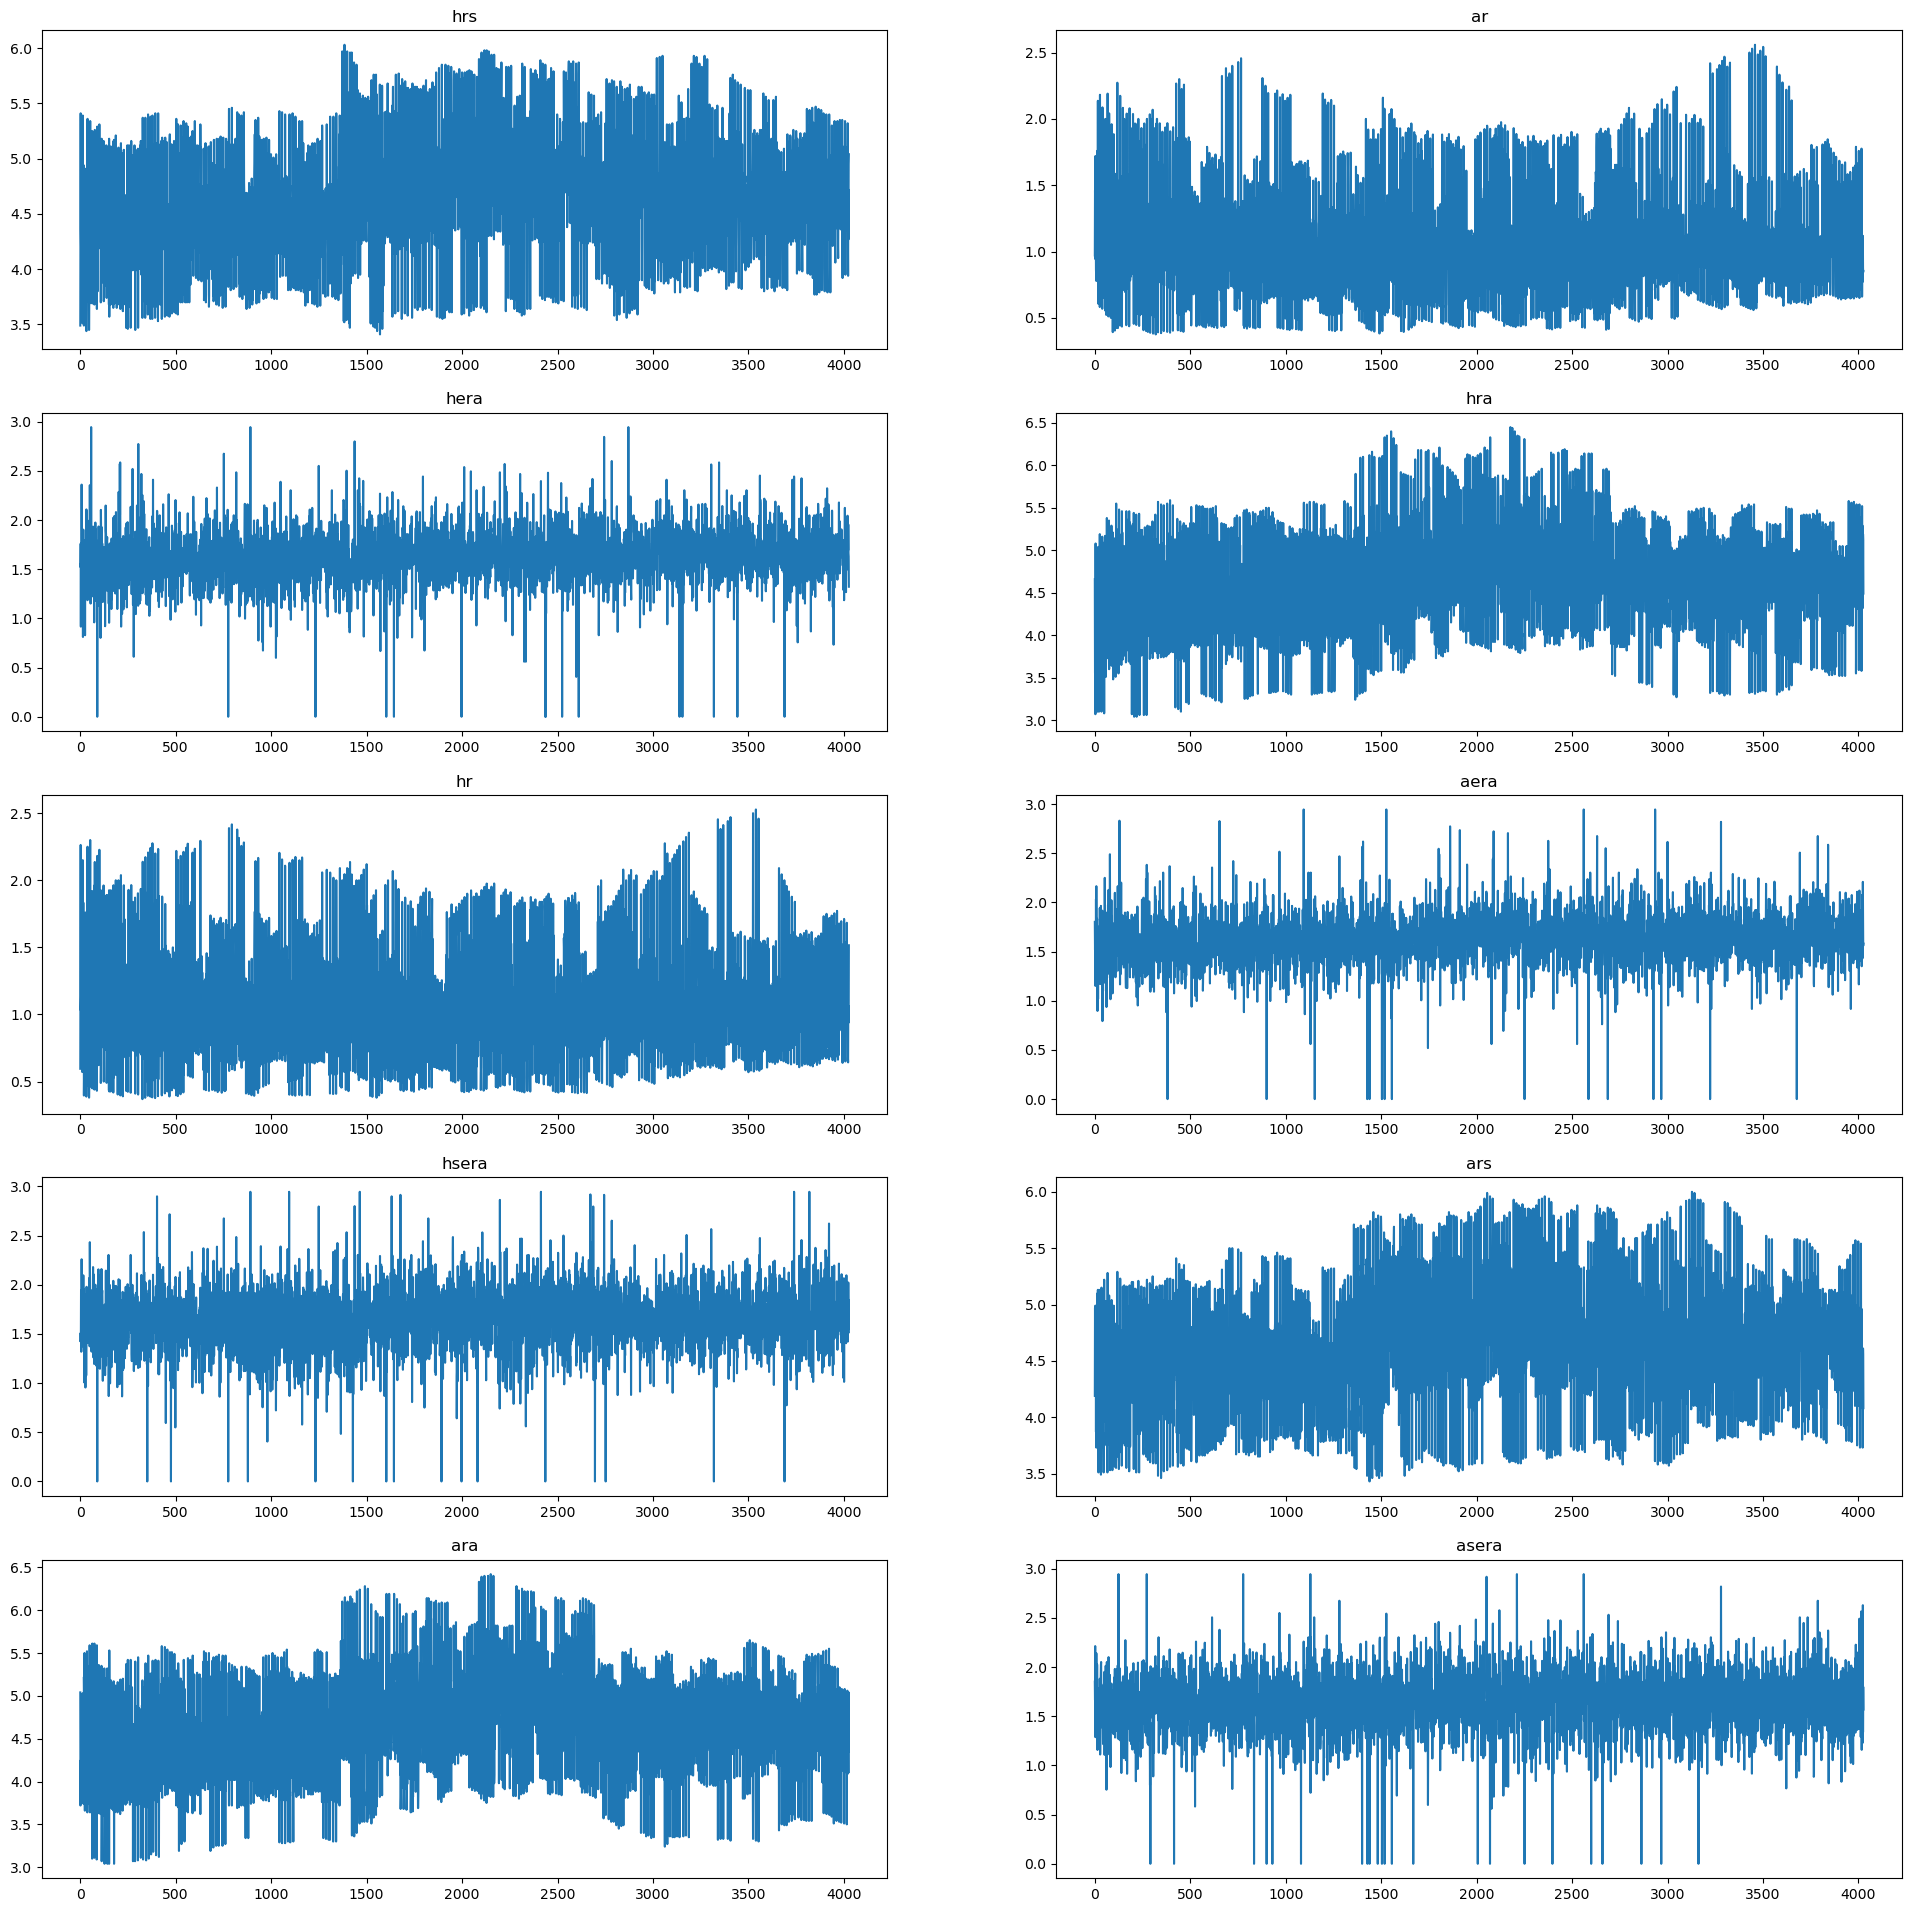

In [49]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(24, 24))

x = data.columns.drop(['winner'])

for i,var in enumerate(x):
    data[var].plot(ax=axes[i%5][i%2], title=var)

In [20]:
class DataFrameColumnTransformer(TransformerMixin):
    def __init__(self, stages):
        self.col_trans = ColumnTransformer(stages)
    
    def fit(self, X: pd.DataFrame):
        """ Runs our ColumnTransformer.fit() method """
        self.col_trans.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """ Runs our ColumnTransformer.transform() method """
        output_arr = self.col_trans.transform(X)
        
        return self.to_dataframe(output_arr)
    
    def to_dataframe(self, arr: np.ndarray) -> pd.DataFrame:
        """Converts our output of ColumnTransformer into a DataFrame"""
        feature_names = self.col_trans.get_feature_names_out()
        
        # Remove the "__" that ColumnTransformer adds to our feature names
        # when we call self.col_trans.get_feature_names_out()
        for i, name in enumerate(feature_names):
            if '__' in name:
                feature_names[i] = name.split('__', 1)[-1]
        
        # Creates a Pandas Dataframe
        df = pd.DataFrame(arr, columns=feature_names)
        
        return df

In [21]:
class LogTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        
        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        self.feature_names = X.columns
        
        return np.log1p(X)
    
    def get_feature_names_out(self, names=None):
        return list(self.feature_names)

In [22]:
def before_pipeline(data):
    passthrough_cols = data.drop(['hera', 'aera', 'hsera', 'asera'], axis=1).columns 

    # TODO 3.1
    stages = [('pass', 'passthrough', passthrough_cols),
              ('log', LogTransformer(), ['hera', 'aera', 'hsera', 'asera'])]

    # TODO 3.2
    before_pipe = DataFrameColumnTransformer(stages)
    
    # TODO 3.3
    cleaner_df = before_pipe.fit_transform(data)
    
    return cleaner_df

In [50]:
data = before_pipeline(data)
#testing = before_pipeline(testing)

#y is the value we are trying to predict
train_y = data.winner
#these are the variables we are using to make the prediction
features = ['hrs', 'hra', 'hsera', 'hr', 'hera', 'ars', 'ara', 'asera', 'ar', 'aera']
train_X = data[features]

val_y = testing.winner
val_X = testing[features]

In [51]:
lr = LogisticRegression(random_state  = 41)

lr.fit(train_X, train_y)
lr_preds = lr.predict(val_X)
#print(mean_absolute_error(val_y, lr_preds))
print("Logistic Regression: ")
print(accuracy_score(val_y, lr_preds))

Logistic Regression: 
0.5597295266716754


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
pipe = make_pipeline(StandardScaler(),
                     LogisticRegression())

pipe.fit(train_X, train_y)
p_preds = pipe.predict(val_X)

print("Logistic Regression w/ Pipeline: ")
print(accuracy_score(val_y, p_preds))

Logistic Regression w/ Pipeline: 
0.5597295266716754
